In [282]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from cleaning_utils import * # import all existing functions from file cleaning.py

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Blight Data

In [258]:
blight = pd.read_csv('../P3_data/Blight_Violations.csv')

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9,11,15,16,17,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [259]:
blight.head(3)

,X,Y,ticket_id,ticket_number,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,violator_id,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,violation_date,ticket_issued_time,hearing_date,hearing_time,judgment_date,violation_code,violation_description,disposition,clean_up_cost,payment_amount,payment_date,payment_status,collection_status,violation_address,parcelno,oid,geom,fine_amount
0,-83.072573,42.383350,18645,05001700DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dean Byrd,601,KING,NaN,1614,599,King,Det,MI,48202,NaN,NaN,2005/01/13 00:00:00+00,1900/01/01 14:00:00,2005/02/07 00:00:00+00,09:00:00,2005/02/07 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,NaN,NaN,1970/01/01 00:00:00+00,NaN,NaN,601 KING,03002390.,18645,NaN,NaN
1,-83.072479,42.383394,18646,05001701DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Cynthia Roberts,607,KING,NaN,1615,18604,Appoline,Det,MI,48235,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 00:45:00,2005/02/14 00:00:00+00,09:00:00,2019/09/16 10:26:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,607 KING,03002391.,18646,NaN,NaN
2,-83.115061,42.359916,18648,05001703DAH,"Buildings, Safety Engineering & Env Department",Orbie Gailes,Dannny Barnes,4066,COLUMBUS,NaN,1617,4066,Columbus,Det,MI,48204,NaN,NaN,2005/01/14 00:00:00+00,1900/01/01 14:00:00,2005/02/14 00:00:00+00,09:00:00,2005/02/14 00:00:00+00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,NaN,NaN,1970/01/01 00:00:00+00,NO PAYMENT DUE,NaN,4066 COLUMBUS,14002572.,18648,NaN,NaN


In [260]:
blight.shape

(496335, 36)

In [261]:
blight.payment_status.value_counts()

NO PAYMENT DUE             210004
PAID IN FULL                97642
PARTIAL PAYMENT APPLIED      9080
NO PAYMENT APPLIED              2
Name: payment_status, dtype: int64

In [262]:
blight = blight[blight.payment_status == 'PAID IN FULL']

In [263]:
list(blight.columns)

['X',
 'Y',
 'ticket_id',
 'ticket_number',
 'agency_name',
 'inspector_name',
 'violator_name',
 'violation_street_number',
 'violation_street_name',
 'violation_zip_code',
 'violator_id',
 'mailing_address_str_number',
 'mailing_address_str_name',
 'city',
 'state',
 'zip_code',
 'non_us_str_code',
 'country',
 'violation_date',
 'ticket_issued_time',
 'hearing_date',
 'hearing_time',
 'judgment_date',
 'violation_code',
 'violation_description',
 'disposition',
 'clean_up_cost',
 'payment_amount',
 'payment_date',
 'payment_status',
 'collection_status',
 'violation_address',
 'parcelno',
 'oid',
 'geom',
 'fine_amount']

In [264]:
# Selecting not important features to drop from DF

columns_to_drop = [
                 
                 'ticket_number',
                 'agency_name',
                 'inspector_name',
                 'violator_name',
                
                 'violator_id',
                 'mailing_address_str_number',
                 'mailing_address_str_name',
                 'city',
                 'state',
                 'zip_code',
                 'non_us_str_code',
                 'country',
                 
                 'ticket_issued_time',
                 'hearing_date',
                 'hearing_time',
                 
                 'violation_code',
                 'violation_description',
                 'disposition',
                 'clean_up_cost',
                 'payment_amount',
                 
                 
                 'collection_status',
                 'violation_address',
                 
                 'oid',
                 'geom',
                 'fine_amount']

In [265]:
blight = blight.drop(columns=columns_to_drop)

In [266]:
blight.columns

Index(['X', 'Y', 'ticket_id', 'violation_street_number',
       'violation_street_name', 'violation_zip_code', 'violation_date',
       'judgment_date', 'payment_date', 'payment_status', 'parcelno'],
      dtype='object')

In [267]:
blight.shape

(97642, 11)

## Defining Target Variable Compliance

In [268]:
blight.head()

,X,Y,ticket_id,violation_street_number,violation_street_name,violation_zip_code,violation_date,judgment_date,payment_date,payment_status,parcelno
7,-83.019172,42.339196,18653,2900,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/23 00:00:00+00,2005/02/22 08:43:00+00,PAID IN FULL,11000088.014
11,-82.942097,42.388525,18657,15439,MACK,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2005/03/09 13:33:00+00,PAID IN FULL,21001420.
12,-82.946176,42.371778,18658,14214,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/04 00:00:00+00,2005/02/04 10:19:00+00,PAID IN FULL,21000354.
15,-83.045750,42.335121,18661,1310,BROADWAY,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2007/06/12 00:00:00+00,PAID IN FULL,01004004.
18,-83.044467,42.335210,18664,343,MACOMB,NaN,2005/01/14 00:00:00+00,2005/03/23 00:00:00+00,2007/05/31 00:00:00+00,PAID IN FULL,01000207.


In [269]:
blight.violation_date = pd.to_datetime(blight['violation_date']).dt.date
blight.judgment_date = pd.to_datetime(blight['judgment_date']).dt.date
blight.payment_date = pd.to_datetime(blight['payment_date']).dt.date

In [270]:
blight.rename({'Y':'lat', 'X':'lon', 'parcelno': 'parcel_id'}, axis=1, inplace=True)

In [271]:
blight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97642 entries, 7 to 494929
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lon                      59904 non-null  float64
 1   lat                      59904 non-null  float64
 2   ticket_id                97642 non-null  int64  
 3   violation_street_number  97642 non-null  int64  
 4   violation_street_name    97640 non-null  object 
 5   violation_zip_code       35727 non-null  object 
 6   violation_date           97642 non-null  object 
 7   judgment_date            97642 non-null  object 
 8   payment_date             97642 non-null  object 
 9   payment_status           97642 non-null  object 
 10  parcel_id                59904 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.9+ MB


In [272]:
# Create new column compliance - target variable

blight['compliance'] = blight.apply(compliance, axis=1)

In [273]:
blight.compliance.value_counts()

0    65247
1    32395
Name: compliance, dtype: int64

In [274]:
blight.compliance.value_counts(normalize= True)

0    0.668227
1    0.331773
Name: compliance, dtype: float64

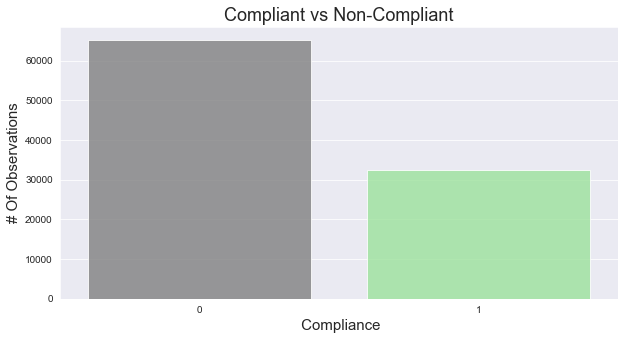

In [275]:
# Compliance Count

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(blight['compliance'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [276]:
blight = blight.dropna(subset=['parcel_id'])

In [278]:
blight['parcel_id'] = blight.apply(parse_parcel,axis=1)

TypeError: argument of type 'int' is not iterable

In [279]:
# applying function coord_bligth

blight['coordinates'] = blight.apply(coord_bligth,axis=1)

In [280]:
blight.coordinates.values[0]

(42.339195641000096, -83.01917209300001)

In [281]:
blight.to_csv(r'data/Blight.csv', index = False)

## Exploring Crime in Neighborhoods with data Reported_Major_Crimes_2011_to_2014

In [283]:
crimes = pd.read_csv('../P3_data/Reported_Major_Crimes_2011_to_2014.csv')

In [284]:
crimes.head()

,ROWNUM,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,NEIGHBORHOOD,CENSUSTRACT,LOCATION,ObjectId
0,1311873,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,0,1103.0,11.0,PERSHING,5066.0,"00 EUREKA/E LANTZ\n(42.4382, -83.0579)",1
1,1311874,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - NON-FAMILY - OTHER WEAPON,13002,2011/01/02 00:00:00+00,11,709.0,7.0,LAFAYETTE PARK,5166.0,"E.LAFAYETTE01800\n(42.3394, -83.0295)",2
2,1311878,LARCENY,"LARCENY - FROM BUILDING (INCLUDES LIBRARY, OFF...",23003,2011/01/02 00:00:00+00,11,1105.0,11.0,OUTER DRIVE VAN DYKE,5051.0,"VANDYKE19900\n(42.4415, -83.0238)",3
3,1311879,LARCENY,LARCENY (OTHER),23007,2011/01/01 00:00:00+00,20,706.0,7.0,CHENE,5188.0,"JOS CAMPAU04100\n(42.3606, -83.0339)",4
4,1311883,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,3,612.0,6.0,WARRENDALE,5457.0,"PIEDMONT06000\n(42.3328, -83.228)",5


In [285]:
crimes = crimes[['LOCATION','CATEGORY','INCIDENTDATE']]

In [286]:
# Using functions extract_lat_crime and extract_long_crime
crimes['lat'] = crimes.LOCATION.map(extract_lat_crime)
crimes['lon'] = crimes.LOCATION.map(extract_long_crime)

In [287]:
crimes['lat'].describe()

count    234978.000000
mean       1833.966961
std       42288.290069
min          39.744700
25%          42.356000
50%          42.391800
75%          42.421300
max      999999.000100
Name: lat, dtype: float64

In [288]:
crimes['lon'].describe()

count    234978.000000
mean       1708.699648
std       42293.597149
min         -84.912300
25%         -83.188300
50%         -83.111700
75%         -83.027100
max      999999.000100
Name: lon, dtype: float64

In [289]:
crimes =  crimes[ (crimes['lat'] < 45) | (crimes['lon'] < 85) ]

In [290]:
crimes['coordinates'] = crimes.apply(coord_bligth, axis=1)

In [291]:
crimes.INCIDENTDATE = pd.to_datetime(crimes['INCIDENTDATE']).dt.date

In [292]:
crimes.to_csv(r'data/Crimes.csv', index = False)

In [237]:
# blight2011 = blight[(blight.violation_date > datetime.date(2011,1,1)) & (blight.violation_date < datetime.date(2011,8,31))]

In [238]:
# blight2011['crime_counts'] = blight2011.apply(crime_count, axis=1, args=[crimes_coord])

In [ ]:
# mcm['ParcelID'] = mcm['D3_SurveyParcelID'].map(lambda x: re.split('\.',x)[0])

In [256]:
# blight.set_index('parcelno').join(mcm.rename(columns={'parcel_id':'parcelno'}).set_index('parcelno'),how='left').dropna(how='all')